## Multimodal RAG using Langchain Expression Language And GPT4-Vision
https://medium.aiplanet.com/multimodal-rag-using-langchain-expression-language-and-gpt4-vision-8a94c8b02d21

### Install required dependencies

In [1]:
# lock to 0.10.19 due to a persistent bug in more recent versions
! pip install --quiet -U pdf2image pytesseract unstructured[all-docs] pillow pydantic lxml pillow matplotlib tiktoken open_clip_torch torch
! pip install --quiet -U langchain openai chromadb langchain-experimental # (newest versions required for multi-modal)
#! apt install poppler-utils
#! apt install tesseract-ocr

### Data Loading

In [2]:
import os

# import shutil
# os.mkdir("Masterpieces")

#! wget "https://www.getty.edu/publications/resources/virtuallibrary/0892360224.pdf"
# shutil.move("0892360224.pdf","Masterpieces")

### Extract images and save it in the required path

In [3]:
path = "E2EQoS/"
file_name = "E2EQoS.pdf"

### Use partition_pdf method below from Unstructured to extract text and images

In [4]:
# Extract images, tables, and chunk text
from unstructured.partition.pdf import partition_pdf

raw_pdf_elements = partition_pdf(
    filename=os.path.join(path, file_name),
    extract_images_in_pdf=True,
    infer_table_structure=True,
    chunking_strategy="by_title",
    max_characters=4000,
    new_after_n_chars=3800,
    combine_text_under_n_chars=2000,
    extract_image_block_output_dir=path,
)

This function will be deprecated in a future release and `unstructured` will simply use the DEFAULT_MODEL from `unstructured_inference.model.base` to set default model name
2024-03-01 02:32:05.517876: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-01 02:32:05.550765: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-01 02:32:05.550784: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-01 02:32:05.552063: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register 

In [5]:
raw_pdf_elements

### Categorize text elements by type

In [6]:
tables = []
texts = []
for element in raw_pdf_elements:
    if "unstructured.documents.elements.Table" in str(type(element)):
        tables.append(str(element))
    elif "unstructured.documents.elements.CompositeElement" in str(type(element)):
        texts.append(str(element))

print(len(tables))
print(len(texts))

5
24


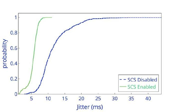

In [7]:
from PIL import Image
from IPython.display import display

# Open the image
img = Image.open(os.path.join(path, os.listdir(path)[-1]))

# Resize the image
resize_ratio = 0.25
new_size = (int(img.size[0] * resize_ratio), int(img.size[1] * resize_ratio))
img_resized = img.resize(new_size)

# Display the image
display(img_resized)

### Multi-modal embeddings with our document

In [8]:
from langchain_community.vectorstores.chroma import Chroma
from langchain_experimental.open_clip import OpenCLIPEmbeddings

# Create chroma
vectorstore = Chroma(
    collection_name="mm_rag_clip_photos",
    embedding_function=OpenCLIPEmbeddings(),
    persist_directory=os.makedirs(os.path.join(path, "vectorstore"), exist_ok=True),
)

# Get image URIs with .jpg extension only
image_uris = sorted([os.path.join(path, image_name) for image_name in os.listdir(path) if image_name.endswith(".jpg")])

# Add images
vectorstore.add_images(uris=image_uris)

# Add documents
vectorstore.add_texts(texts=texts)
vectorstore.add_texts(texts=tables)

vectorstore.persist()

# Make retriever
retriever = vectorstore.as_retriever(
    # search_kwargs={"k": 3},
)

### Retrieval Augmented Generation

In [9]:
import base64
import io


def resize_base64_image(base64_string, size=(128, 128)):
    """
    Resize an image encoded as a Base64 string.

    Args:
    base64_string (str): Base64 string of the original image.
    size (tuple): Desired size of the image as (width, height).

    Returns:
    str: Base64 string of the resized image.
    """
    # Decode the Base64 string
    img_data = base64.b64decode(base64_string)
    img = Image.open(io.BytesIO(img_data))

    # Resize the image
    resized_img = img.resize(size, Image.LANCZOS)

    # Save the resized image to a bytes buffer
    buffered = io.BytesIO()
    resized_img.save(buffered, format=img.format)

    # Encode the resized image to Base64
    return base64.b64encode(buffered.getvalue()).decode("utf-8")


def is_base64(s):
    """Check if a string is Base64 encoded"""
    try:
        return base64.b64encode(base64.b64decode(s)) == s.encode()
    except Exception:
        return False


def split_image_text_types(docs):
    """Split numpy array images and texts"""
    images = []
    text = []
    for doc in docs:
        doc = doc.page_content  # Extract Document contents
        if is_base64(doc):
            # Resize image to avoid OAI server error
            images.append(resize_base64_image(doc, size=(250, 250)))  # base64 encoded str
        else:
            text.append(doc)
    return {"images": images, "texts": text}

In [10]:
from operator import itemgetter

from langchain_openai.chat_models import ChatOpenAI
from langchain_core.messages import HumanMessage
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import (
    RunnableLambda,
    RunnablePassthrough,
    RunnableParallel,
)


def prompt_func(data_dict):
    # Joining the context texts into a single string
    formatted_texts = "\n".join(data_dict["context"]["texts"])
    messages = []

    # Adding image(s) to the messages if present
    if data_dict["context"]["images"]:
        image_message = {
            "type": "image_url",
            "image_url": {"url": f"data:image/jpeg;base64,{data_dict['context']['images'][0]}"},
        }
        messages.append(image_message)

    # Adding the text message for analysis
    text_message = {
        "type": "text",
        "text": (
            "As a secretary, your task is to extract and interpret both textual and visual information from the document, "
            "leveraging the rich context provided. The content has been sourced based on specific keywords "
            "input by the user. **If the document does not contain direct references or clear data relevant to the "
            "user's query, you must clearly state 'No sufficient reference available to provide an answer' and "
            "refrain from answering further.** This directive is to ensure the integrity of the information provided, "
            "avoiding unsubstantiated assumptions or hallucinations. When possible, focus on generating a detailed summary that includes:\n"
            "- Key points and themes extracted from the text.\n"
            "- Descriptions and analyses of any images or visual data.\n"
            "- The relevance and connection of the visual and textual content to the user's query.\n"
            "- Any additional insights or interpretations that can be derived from the combined data, "
            "while ensuring accuracy and reliability.\n\n"
            f"Keywords provided by the user: {data_dict['question']}\n\n"
            "Extracted content:\n"
            f"{formatted_texts}"
        ),
    }
    messages.append(text_message)

    return [HumanMessage(content=messages)]

### Return Source Documents

In [11]:
model = ChatOpenAI(temperature=0, model="gpt-4-vision-preview", max_tokens=1024)

# RAG pipeline
chain = {
    "context": retriever | RunnableLambda(split_image_text_types),
    "question": RunnablePassthrough(),
} | RunnableParallel(
    {
        "response": prompt_func | model | StrOutputParser(),
        "context": itemgetter("context"),
    }
)

### Invoke the RAG Question Answering Chain

### Helper function for displaying images related to the text retrieved

In [12]:
from IPython.display import HTML


def plt_img_base64(img_base64):
    # Create an HTML img tag with the base64 string as the source
    image_html = f'<img src="data:image/jpeg;base64,{img_base64}" />'

    # Display the image by rendering the HTML
    display(HTML(image_html))

In [13]:
from langchain_community.callbacks.manager import get_openai_callback


def displayRAG(question):
    print("###QUESTION###")
    print(question, end="\n\n")

    with get_openai_callback() as callback:
        response = chain.invoke(question)
        print(callback, end="\n\n")

    print("###ANSWER###")
    print(response["response"], end="\n\n")

    for i, image in enumerate(response["context"]["images"]):
        print(f"###IMAGE{i+1}###")
        plt_img_base64(image)

    for i, text in enumerate(response["context"]["texts"]):
        print(f"###TEXT{i+1}###")
        print(text, end="\n\n")

### Question 1

In [14]:
displayRAG("Is there any method of improving WiFi latency?")

###QUESTION###
Is there any method of improving WiFi latency?

Tokens Used: 2399
	Prompt Tokens: 2021
	Completion Tokens: 378
Successful Requests: 1
Total Cost (USD): $0.031549999999999995

###ANSWER###
Key points and themes extracted from the text:
- The document discusses methods to optimize Quality of Service (QoS) over Wi-Fi links, particularly in the context of internet/cloud gaming and enterprise conferencing.
- It highlights the importance of smooth frame rendering and response times in gaming, with specific metrics such as freeze count and motion to photon latency.
- Mitigation strategies for improving Wi-Fi latency include traffic prioritization, maintaining QoS tags, wireless channel selection, and deployment of mechanisms to combat bufferbloat.
- The document also addresses the need for prioritizing certain applications over others in an enterprise setting, based on the time of day and business criticality.

Descriptions and analyses of any images or visual data:
- Figure 5 

### Question 2

In [15]:
displayRAG("Woman with children")

###QUESTION###
Woman with children

Tokens Used: 1999
	Prompt Tokens: 1990
	Completion Tokens: 9
Successful Requests: 1
Total Cost (USD): $0.02017

###ANSWER###
No sufficient reference available to provide an answer.

###TEXT1###
2.2.5 Internet / Cloud Gaming

Description: Video game hosted in internet rendered to a single user within the home (e.g., GeForce Now, Xbox Cloud Gaming), e.g., Modern multiplayer action games – Battlefield series, Fortnite, modern single player action games – Cyberpunk 2077, Facebook Wild Hunt.

Report Title:

Optimizing QoS Over Wi-Fi Links

Issue Date:

October 2023

10

Version:

Version:

1.1.0

Wireless Broadband Alliance © 2023

Wireless Broadband Alliance

Client Cloud gaming Server User Input Gaming Server Frame render Frame decoding ane gerbe Encoder & Stream

FIGURE 5 INTERNET/CLOUD GAMING (LATENCY BOUND)

QoE: Smooth (no perceptible video artifacts) frame rendering and unnoticeable response for a user generated input command.

1. Freeze Count: Fre

### Question 3

In [16]:
displayRAG("Moses and the Messengers from Canaan")

###QUESTION###
Moses and the Messengers from Canaan

Tokens Used: 1675
	Prompt Tokens: 1666
	Completion Tokens: 9
Successful Requests: 1
Total Cost (USD): $0.01693

###ANSWER###
No sufficient reference available to provide an answer.

###TEXT1###
2.4.1 Audio / Video / Data Conferencing

Conference calls within the Enterprise enable collaboration without complicating the participants’ schedules too much (eliminates time for the participants to travel to the meeting location, allows for participants to multi-task, etc.). However, for the conference call to be productive, the quality of voice, data and video should be perfect, so that the discussions, debates, and outcomes are equivalent to what it would have been if the participants met face-to-face.

Report Title:

Optimizing QoS Over Wi-Fi Links

Issue Date:

October 2023

13

Version:

Version:

1.1.0

Wireless Broadband Alliance © 2023

Wireless Broadband Alliance

Mandating a specific conferencing application configured specifically